## Проект по анализу данных

In [1]:
import numpy as np  # для матричных вычислений
import pandas as pd # для анализа и предобработки данных
import matplotlib.pyplot as plt # для визуализации
import seaborn as sns # для визуализации
from sklearn.preprocessing import StandardScaler # шкалирование данных
from sklearn.model_selection import train_test_split # разделение выборки
from sklearn.linear_model import LogisticRegression # логистическая регрессия
from sklearn import metrics # метрики
from sklearn.metrics import f1_score # метрика f1_score
from sklearn.metrics import accuracy_score # метрика accuracy_score
from sklearn.metrics import make_scorer # метрика make_scorer
from sklearn import ensemble # ансамбли
from sklearn.neighbors import KNeighborsClassifier # knn
from xgboost import XGBClassifier # xgboost
from catboost import CatBoostClassifier # catboost
from sklearn.ensemble import StackingClassifier # стекинг
from sklearn.ensemble import RandomForestClassifier # 
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier # adaboost
from sklearn.tree import DecisionTreeClassifier # дерево решений
from sklearn.ensemble import GradientBoostingClassifier # градиентный бустинг
from sklearn.model_selection import GridSearchCV # gridsearchcv
# Загружаем библиотеки, которыми будем пользоваться в ходе исследования
import warnings
warnings.filterwarnings("ignore")

# Данные и пропуски 

Рассмотрим данные про титаник. Данные взяты с сайта https://www.kaggle.com/c/titanic/data.

Данные:
* train.csv - обучающий набор данных с предоставленным результатом
* test.csv - набор тестовых данных без предоставления исхода 
* gender_submission.csv - пример, как должен выглядеть файл с нашими предсказаниями


Признаки:
* survived - выживание 0 = нет, 1 = да
* pclass - класс билета 1 = 1-й, 2 = 2-й, 3 = 3-й
* sex - пол
* age - возраст в годах
* sibsp - количество братьев и сестер/супругов на борту Титаника
* parch - количество родителей/детей на борту Титаника
* ticket -  номер билета
* fare - стоимость билета
* cabin - номер каюты
* embarked - прибыл в порт посадки C = Шербур, Q = Квинстаун, S = Саутгемптон

Целевая переменная survived определяет, выжил ли человек после крушения Титаника. Именно survived мы будем пытаться предсказать в данном кейсе.

### Загрузка данных

In [2]:
train = pd.read_csv('train.csv')
train.head(1)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,NaN,S


In [3]:
test = pd.read_csv('test.csv')
test.head(1)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q


## Первичная обработка данных

Выясним, есть ли в данных пропущенные значения (пустые, незаполненные ячейки) в train.

In [4]:
# Смотрим на количество пропусков в колонках train
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Заменим пропуски в train. В колонке с названием порта прибытия вставим показатель моды.

In [5]:
# Заменим пропущенные значения в embarked на моду по всему столбцу
train.Embarked = train.Embarked.fillna(train.Embarked.mode()[0])

Посмотрим, какой процент пропущенных значений составляет столбик cabin.

In [6]:
print(f'Процент пропущенных значений cabin в train: {round(train.Cabin.isnull().sum()*100/train.shape[0], 2)}')
# Показатель 77.1% настолько высокий, что имеет смысл удалить всю колонку Cabin

Процент пропущенных значений cabin в train: 77.1


In [7]:
# Посмотрим на процент пропущенных значений cabin на test
print(f'Процент пропущенных значений cabin в test: {round(test.Cabin.isnull().sum()*100/train.shape[0], 2)}')
# Показатель 36.7% также сравнительно высокий, удаляем всю колонку Cabin

Процент пропущенных значений cabin в test: 36.7


In [8]:
# Удаляем колонку cabin для train и test
train = train.drop(['Cabin'], axis=1)
test = test.drop(['Cabin'], axis=1)

Заменим пропущенные значения возраста медианными показателями для людей соотвествующего пола.

In [9]:
train[train.Sex == 'female'] = train[train.Sex == 'female'].fillna(train.groupby('Sex')['Age'].median()[0])
train[train.Sex == 'male'] = train[train.Sex == 'male'].fillna(train.groupby('Sex')['Age'].median()[1])

Рассмотрим пропуски в test.

In [10]:
test.isnull().sum()

PassengerId     0
Pclass          0
Name            0
Sex             0
Age            86
SibSp           0
Parch           0
Ticket          0
Fare            1
Embarked        0
dtype: int64

Заменим пропущенное значение стоимости билета медианным показателем по классу соотвесвующего билета.

In [11]:
test.Fare = test.Fare.fillna(test[test.Pclass == test[test.Fare.isnull()].Pclass.values[0]].Fare.median())

In [12]:
test[test.Sex == 'female'] = test[test.Sex == 'female'].fillna(test.groupby('Sex')['Age'].median()[0])
test[test.Sex == 'male'] = test[test.Sex == 'male'].fillna(test.groupby('Sex')['Age'].median()[1])

Удалим столбцы, которые не будут способствовать увеличиванию пердсказательный силы модели.

In [13]:
train = train.drop(['PassengerId', 'Name', 'Ticket'], axis=1)
test = test.drop(['PassengerId', 'Name', 'Ticket'], axis=1)

Обратим внимание, что показатель пола задан как male/female. Перекодируем стобец так, что 1 - женщины, 0 - мужчины.

In [14]:
train['Sex'] = train['Sex'].apply(lambda x: 1 if x == 'female' else 0)
test['Sex'] = test['Sex'].apply(lambda x: 1 if x == 'female' else 0)

Создадим для показателя прибытия в порт бинарные переменны.

In [15]:
train = pd.get_dummies(train)
test = pd.get_dummies(test)

Проверим, не были ли пропущены важные этапы предобработки данных, еще раз посмотрев на данные.

In [16]:
train.head(1)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S
0,0,3,0,22.0,1,0,7.25,False,False,True


In [17]:
test.head(1)

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S
0,3,0,34.5,0,0,7.8292,False,True,False


Рассмотрим корреляцию данных между собой, включая предсказываемую переменную, выжил ли человек. Для это построим корреляционную матрицу. Это поможет нам:
* заметить наличие/отсутствие мультиколлинеарности
* рассмотрим корреляцию с зависимой переменной, что позволит сформулировать гипотезы

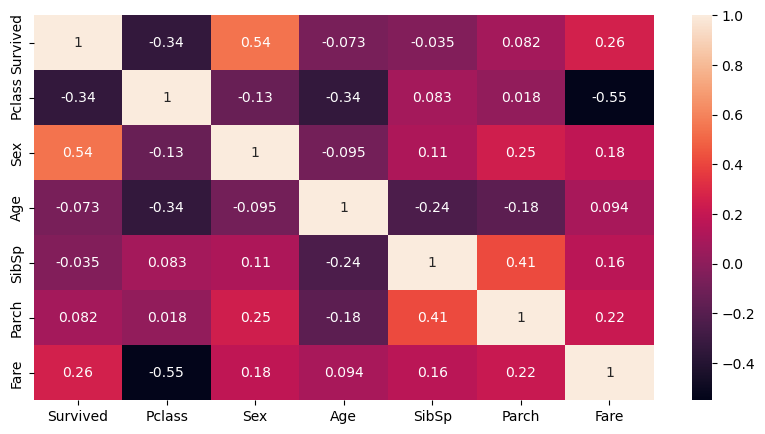

In [18]:
plt.figure(figsize = (10, 5))
sns.heatmap(train.select_dtypes('number').corr(), annot = True);

Самым большим показателем в таблице является 55% корреляция между классом билета и стоимостью билета, что выглядит вполне логично. Данные показатели буду сохранены в таблице, как и те, которые коррелируют меньше: как правило высоким уровнем корреляции мы считаем 70% и больше.

Рассмотрим корреляцию показателей с предсказываемой переменной survived. Здесь выделяются два ключевых показателя: класс билета (34%) и стоимостью билета (26%).

Рассмотрим распределение предсказываемой переменной. Это поможет нам узнать, есть ли дисбаланс в данных.

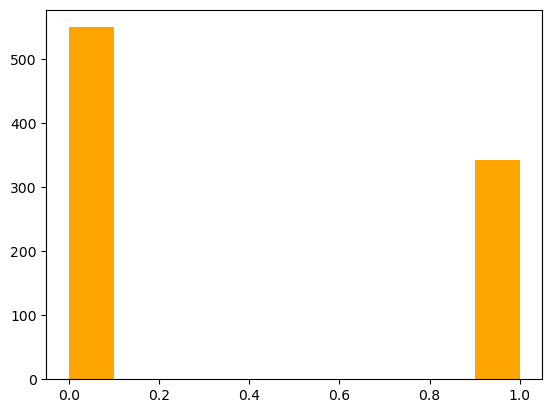

In [19]:
plt.hist(train.Survived, color="orange");

## Перейдем к разделу построения моделей

In [20]:
# В X запишем все предсказувающие переменные
X = train.drop(['Survived'], axis=1)
# В y запишем предсказываемую переменную survived
y = train['Survived']

In [21]:
# На 67% наблюдений модель будет обучаться, а на 33% мы будем проверять качество модели
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.33)

In [22]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## Логистическая регрессия

Модель логистической регрессии будет нашим бенчмарком, с которым мы будем сравнивать все остальные модели.

In [23]:
model_lr = LogisticRegression()

model_lr.fit(X_train, y_train)

preds_test = model_lr.predict(X_test)

print(metrics.classification_report(y_test, preds_test))

              precision    recall  f1-score   support

           0       0.83      0.87      0.85       175
           1       0.80      0.73      0.77       120

    accuracy                           0.82       295
   macro avg       0.81      0.80      0.81       295
weighted avg       0.82      0.82      0.82       295



In [24]:
log_reg = LogisticRegression(
    solver='sag',
    random_state=1,
    max_iter=1000
)

log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=1, solver='sag')

In [25]:
y_train_pred = log_reg.predict(X_train)
print(metrics.classification_report(y_train, y_train_pred))

y_test_pred = log_reg.predict(X_test)
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.82      0.86      0.84       374
           1       0.75      0.68      0.72       222

    accuracy                           0.80       596
   macro avg       0.79      0.77      0.78       596
weighted avg       0.79      0.80      0.79       596

              precision    recall  f1-score   support

           0       0.83      0.87      0.85       175
           1       0.80      0.73      0.77       120

    accuracy                           0.82       295
   macro avg       0.81      0.80      0.81       295
weighted avg       0.82      0.82      0.82       295



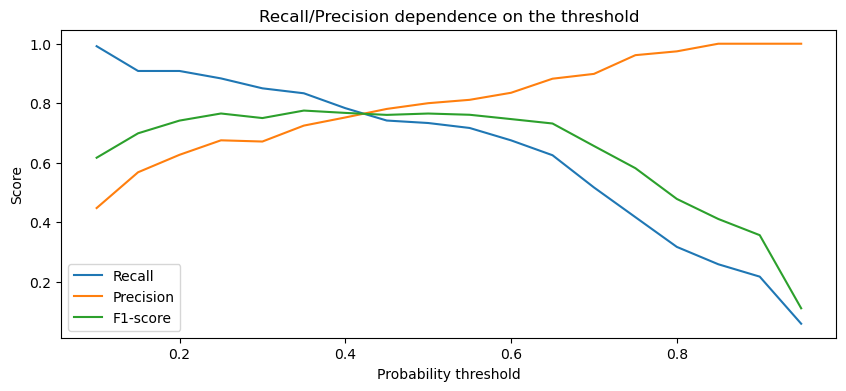

In [26]:
y_test_proba_pred = log_reg.predict_proba(X_test)[:, 1]
y_test_proba_pred = pd.Series(y_test_proba_pred)

recall_scores = []
precision_scores = []
f1_scores = []

thresholds = np.arange(0.1, 1, 0.05)

for threshold in thresholds:
    y_test_pred = y_test_proba_pred.apply(lambda x: 1 if x>threshold else 0)
    recall_scores.append(metrics.recall_score(y_test, y_test_pred))
    precision_scores.append(metrics.precision_score(y_test, y_test_pred))
    f1_scores.append(metrics.f1_score(y_test, y_test_pred))

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(thresholds, recall_scores, label='Recall')
ax.plot(thresholds, precision_scores, label='Precision')

ax.plot(thresholds, f1_scores, label='F1-score')
ax.set_title('Recall/Precision dependence on the threshold')
ax.set_xlabel('Probability threshold')
ax.set_ylabel('Score')
ax.legend();

In [27]:
#Задаем оптимальный порог вероятностей
threshold_opt = 0.52
#Людей, у которых вероятность зарабатывать >50K больше 0.4 относим к классу 1
#В противном случае - к классу 0
y_test_pred_opt = y_test_proba_pred.apply(lambda x: 1 if x > threshold_opt else 0)
#Считаем метрики
print(metrics.classification_report(y_test, y_test_pred_opt))

              precision    recall  f1-score   support

           0       0.82      0.88      0.85       175
           1       0.81      0.72      0.76       120

    accuracy                           0.82       295
   macro avg       0.81      0.80      0.81       295
weighted avg       0.82      0.82      0.82       295



Запомним, что для логистической регрессии наилучшим показателем f1 score было 0.82. Это означает, что наши предсказания оказывались верными в 82% и в 18% случаев мы ошибались. Запомним данный показатель и будет сравнивать с ним другие модели.

## Дерево решений

In [28]:
#Создаем объект класса дерево решений
# В целом есть DecisionTreeClassifier, а есть DecisionTreeRegressor
dt = DecisionTreeClassifier(
    criterion='entropy', # это значит, что дерево строится так, чтобы на каждом шаге уменьшалась неопределенность
    #min_samples_leaf=5,
    #max_depth=8, У нас тут задаются вопросы до тех пор, пока в каждом листочке останется 1 объект, переобученность
    random_state=42
)
#Обучаем дерево по алгоритму CART
dt.fit(X_train, y_train)
#Выводим значения метрики 
y_train_pred = dt.predict(X_train)
print('Train: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = dt.predict(X_test)
print('Test: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Train: 0.97
Test: 0.74


Предсказательная сила для дерева решений относительно невысокая и составляет всего 0.74 на тестовой выборке. Пока сохраняем предпочтение в пользу логистической регрессии.

## Случайный лес

In [29]:
rf = ensemble.RandomForestClassifier(
    n_estimators=500,
    max_depth=15,
    criterion='entropy',
    min_samples_leaf=10,
    random_state=42
)


rf.fit(X_train, y_train)
y_train_pred = rf.predict(X_train)
print('Train: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))

y_test_pred = rf.predict(X_test)
print('Test: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Train: 0.77
Test: 0.74


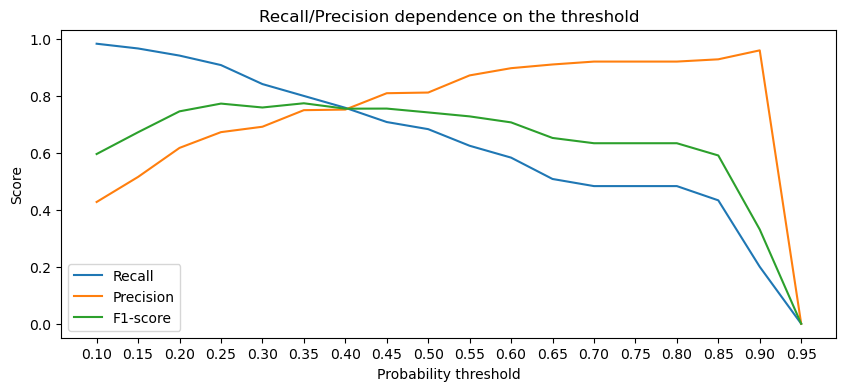

In [30]:
y_test_proba_pred = rf.predict_proba(X_test)[:, 1]

y_test_proba_pred = pd.Series(y_test_proba_pred)

recall_scores = []
precision_scores = []
f1_scores = []

thresholds = np.arange(0.1, 1, 0.05)

for threshold in thresholds:
    y_test_pred = y_test_proba_pred.apply(lambda x: 1 if x>threshold else 0)
    recall_scores.append(metrics.recall_score(y_test, y_test_pred))
    precision_scores.append(metrics.precision_score(y_test, y_test_pred))
    f1_scores.append(metrics.f1_score(y_test, y_test_pred))

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(thresholds, recall_scores, label='Recall')
ax.plot(thresholds, precision_scores, label='Precision')

ax.plot(thresholds, f1_scores, label='F1-score')
ax.set_title('Recall/Precision dependence on the threshold')
ax.set_xlabel('Probability threshold')
ax.set_ylabel('Score')
ax.set_xticks(thresholds)
ax.legend();

In [31]:
threshold_opt = 0.5
y_test_pred_opt = y_test_proba_pred.apply(lambda x: 1 if x > threshold_opt else 0)
print(metrics.classification_report(y_test, y_test_pred_opt))

              precision    recall  f1-score   support

           0       0.80      0.89      0.85       175
           1       0.81      0.68      0.74       120

    accuracy                           0.81       295
   macro avg       0.81      0.79      0.79       295
weighted avg       0.81      0.81      0.80       295



Со случайным лесмо мы получаем аналогичную картину. Пусть показатель точности предсказывания уже выше, чем в дереве решений и accuracy составляет 0.81, но это все еще ниже accuracy логистической регрессии 0.82.

## Knn

In [32]:
# Обычно не ставят четное число в n_neighbors = 10 по причине того, что модель можем не считать, куда отнести точку.
# Тем не менее, эмпирически проверив модели с разным количеством n_neighbors, оказалось, что показатель 10,
# позволяет предсказывать лучше всего
knn = KNeighborsClassifier(n_neighbors = 10)

knn.fit(X_train, y_train)

y_pred_knn = knn.predict(X_test)

p_pred_knn = knn.predict_proba(X_test)

accuracy_score(y_test, y_pred_knn)

0.8101694915254237

Также показатель качества knn модели немного уступает аналогичному показателю для логистической регрессии, которой мы отдаем предпочтение.

## Градиентный бустинг

In [33]:
model_for_gs = GradientBoostingClassifier()
params = {"n_estimators": 2**np.arange(8), "learning_rate": 0.1**np.arange(3)}
gs = GridSearchCV(estimator = model_for_gs,
                 param_grid = params,
                 cv=3,
                 scoring = make_scorer(f1_score),
                 verbose = 5)

gs.fit(X_train, y_train)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV 1/3] END .learning_rate=1.0, n_estimators=1;, score=0.755 total time=   0.0s
[CV 2/3] END .learning_rate=1.0, n_estimators=1;, score=0.662 total time=   0.0s
[CV 3/3] END .learning_rate=1.0, n_estimators=1;, score=0.757 total time=   0.0s
[CV 1/3] END .learning_rate=1.0, n_estimators=2;, score=0.763 total time=   0.0s
[CV 2/3] END .learning_rate=1.0, n_estimators=2;, score=0.621 total time=   0.0s
[CV 3/3] END .learning_rate=1.0, n_estimators=2;, score=0.632 total time=   0.0s
[CV 1/3] END .learning_rate=1.0, n_estimators=4;, score=0.716 total time=   0.0s
[CV 2/3] END .learning_rate=1.0, n_estimators=4;, score=0.618 total time=   0.0s
[CV 3/3] END .learning_rate=1.0, n_estimators=4;, score=0.694 total time=   0.0s
[CV 1/3] END .learning_rate=1.0, n_estimators=8;, score=0.732 total time=   0.0s
[CV 2/3] END .learning_rate=1.0, n_estimators=8;, score=0.620 total time=   0.0s
[CV 3/3] END .learning_rate=1.0, n_estimators=8;

GridSearchCV(cv=3, estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': array([1.  , 0.1 , 0.01]),
                         'n_estimators': array([  1,   2,   4,   8,  16,  32,  64, 128])},
             scoring=make_scorer(f1_score), verbose=5)

In [34]:
print('Лучшие гиперпараметры:', gs.best_params_)
print('Лучшие значения метрики:', gs.best_score_)

Лучшие гиперпараметры: {'learning_rate': 1.0, 'n_estimators': 1}
Лучшие значения метрики: 0.7247174394233218


## AdaBoost

In [35]:
dt = DecisionTreeClassifier(
    random_state=26
)

ada = AdaBoostClassifier(
    estimator=dt,
    random_state=26,
    learning_rate = 0.01
)

ada.fit(X_train, y_train)

ada_pred  = ada.predict(X_test)

f1_score(ada_pred, y_test)

0.6748971193415637

## Стекинг

In [36]:
estimators = [
    ('lr', LogisticRegression()),
    ('rf', RandomForestClassifier(),
     'gb', GradientBoostingClassifier())
]

reg = StackingClassifier(
    estimators=estimators,
    final_estimator=RandomForestClassifier(n_estimators=10,
                                          random_state=42) 
)

reg.fit(X_train, y_train)

StackingClassifier(estimators=[('lr', LogisticRegression()),
                               ('rf', RandomForestClassifier(), 'gb',
                                GradientBoostingClassifier())],
                   final_estimator=RandomForestClassifier(n_estimators=10,
                                                          random_state=42))

In [37]:
y_pred_stack = reg.predict(X_test)

print(metrics.classification_report(y_test, y_pred_stack))

              precision    recall  f1-score   support

           0       0.76      0.87      0.81       175
           1       0.76      0.60      0.67       120

    accuracy                           0.76       295
   macro avg       0.76      0.73      0.74       295
weighted avg       0.76      0.76      0.75       295



In [38]:
feature_importances = rf.feature_importances_  # rf - наша обученная модель 
X_train = pd.DataFrame(X_train, columns = X.columns)
feature_names = X_train.columns  # X_train содержит наши факторы

importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importances_df = importances_df.sort_values('Importance', ascending=False) # поставим значимость по убыванию

top3_features = importances_df.head(3)
print(top3_features)

  Feature  Importance
1     Sex    0.432993
5    Fare    0.178510
0  Pclass    0.154009


## XGBoost

In [39]:
model_xgb = XGBClassifier(random_state = 26)
model_xgb.fit(X_train, y_train)
preds_test = model_xgb.predict(X_test)

f1_score(preds_test, y_test)

0.7426160337552742

Мы видим, что показатели точности моделей градиентного бустинга, adaboost, стекинга моделей логистической регрессии, случайного леса и градиентного бустинга, а также XGBoost усупают в качестве логистической регрессии.

Также мы узнали, что в стекинге ключевыми показателями предсказания выживаемости являются пол, стоимость билета и класс каюты проживания.

## CatBoost

In [40]:
model = CatBoostClassifier(random_state = 26)
model.fit(X_train, y_train)
preds_class = model.predict(X_test)

f1_score(preds_class, y_test)

Learning rate set to 0.00826
0:	learn: 0.6900619	total: 55ms	remaining: 54.9s
1:	learn: 0.6862798	total: 56.7ms	remaining: 28.3s
2:	learn: 0.6806203	total: 59ms	remaining: 19.6s
3:	learn: 0.6756412	total: 61.5ms	remaining: 15.3s
4:	learn: 0.6723143	total: 63ms	remaining: 12.5s
5:	learn: 0.6672785	total: 65.7ms	remaining: 10.9s
6:	learn: 0.6628312	total: 67.4ms	remaining: 9.56s
7:	learn: 0.6577960	total: 69.7ms	remaining: 8.64s
8:	learn: 0.6529357	total: 72ms	remaining: 7.93s
9:	learn: 0.6480698	total: 74.1ms	remaining: 7.34s
10:	learn: 0.6439928	total: 75.8ms	remaining: 6.82s
11:	learn: 0.6400849	total: 78.2ms	remaining: 6.44s
12:	learn: 0.6353338	total: 80.8ms	remaining: 6.14s
13:	learn: 0.6320788	total: 82.6ms	remaining: 5.82s
14:	learn: 0.6294693	total: 84.3ms	remaining: 5.54s
15:	learn: 0.6251411	total: 86.4ms	remaining: 5.32s
16:	learn: 0.6225743	total: 87.9ms	remaining: 5.08s
17:	learn: 0.6186514	total: 90.1ms	remaining: 4.92s
18:	learn: 0.6158414	total: 92.1ms	remaining: 4.75s
1

0.7454545454545455

In [41]:
preds_class_train = model.predict(X_train)
f1_score(preds_class_train, y_train)

0.8400000000000001

С Catboost моделью мы пусть и хорошо предсказываем для трейна, но недостаточно хорошо предсказываем для тестовых данных. Данная моедль снова проигрывает логистической регрессии.

In [42]:
pd.DataFrame(
    {
      'feature importance': model.get_feature_importance(),  
      'feature names':train.drop(columns = 'Survived').columns,  
    }
).sort_values(by=['feature importance'], ascending = False)

,feature importance,feature names
1,35.476017,Sex
0,16.949178,Pclass
2,15.844434,Age
5,15.569627,Fare
3,5.702986,SibSp
4,4.003477,Parch
8,2.853818,Embarked_S
6,2.384509,Embarked_C
7,1.215955,Embarked_Q


Ключевым факторами для предсказания, выживет ли пассажир титаника или нет, являются пол, класс каюты, возраст и стоимость билета. 

В конце мы можем сделать ключевые генеральный вывод для всех построенных моделей, что логистическая регрессия - наш бенчмарк - проявила себя лучше остальных моделей с показателем accuracy на тестовых данных 0.82.